In [1]:
import math
import scipy.special,scipy.linalg
import numpy as np
import time
from matplotlib import pyplot as plt
#from sklearn.datasets import fetch_mldata
from tensorflow.keras.datasets import mnist,fashion_mnist

## GENERATE DATA

In [2]:
def gen_data(testcase,Tr,Te,prop,means=None,covs=None):
    rng = np.random
    
    if testcase is 'MNIST':
        #mnist=fetch_mldata('MNIST original')
        (X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()
        X_train_full = X_train_full.reshape(-1,784)
        X_test_full = X_test_full.reshape(-1,784)
        #X,y = mnist.data,mnist.target
        #X_train_full, X_test_full = X[:60000], X[60000:]
        #y_train_full, y_test_full = y[:60000], y[60000:]

        selected_target = [7,9]
        K=len(selected_target)
        X_train = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)        
        
        y_train = []
        y_test = []
        ind=0
        for i in selected_target:
            locate_target_train = np.where(y_train_full==i)[0][range(np.int(prop[ind]*Tr))]
            locate_target_test  = np.where(y_test_full==i)[0][range(np.int(prop[ind]*Te))]
            X_train = np.concatenate( (X_train,X_train_full[locate_target_train].T),axis=1)
            y_train = np.concatenate( (y_train,2*(ind-K/2+.5)*np.ones(np.int(Tr*prop[ind]))) )
            X_test  = np.concatenate( (X_test,X_test_full[locate_target_test].T),axis=1)
            y_test = np.concatenate( (y_test,2*(ind-K/2+.5)*np.ones(np.int(Te*prop[ind]))) )
            ind+=1                       
        
        X_train = X_train - np.mean(X_train,axis=1).reshape(p,1)
        X_train = X_train*np.sqrt(784)/np.sqrt(np.sum(X_train**2,(0,1))/Tr)
        
        X_test = X_test - np.mean(X_test,axis=1).reshape(p,1)
        X_test = X_test*np.sqrt(784)/np.sqrt(np.sum(X_test**2,(0,1))/Te)
        
    else:
        X_train = np.array([]).reshape(p,0)
        Omega = np.array([]).reshape(p,0)
        X_test = np.array([]).reshape(p,0)       
        y_train = []
        y_test = []
        K = len(prop)
        for i in range(K):    
            tmp = rng.multivariate_normal(means[i], covs[i], size=np.int(Tr * prop[i])).T
            X_train = np.concatenate((X_train,rng.multivariate_normal(means[i],covs[i],size=np.int(Tr*prop[i])).T),axis=1)
            Omega = np.concatenate((Omega, tmp - np.outer(means[i], np.ones((1, np.int(Tr * prop[i]))))), axis=1)
            X_test  = np.concatenate((X_test, rng.multivariate_normal(means[i],covs[i],size=np.int(Te*prop[i])).T),axis=1)
            y_train = np.concatenate( (y_train,2*(i-K/2+.5)*np.ones(np.int(Tr*prop[i]))) )
            y_test = np.concatenate( (y_test,2*(i-K/2+.5)*np.ones(np.int(Te*prop[i]))) )            
            
    X_train = X_train/math.sqrt(p)
    X_test  = X_test/math.sqrt(p)
            
    return X_train, X_test, y_train, y_test

## Generate σ(⋅) activation functions

In [3]:
import scipy
from scipy.special import erfc
def gen_sig(fun,Z,tau, polynom=None, s1=None, s2=None):
    
    if fun is 'poly2':
        sig = polynom[0]*Z**2+polynom[1]*Z+polynom[2]
    elif fun is 'ReLu':
        sig = np.maximum(Z,0)
        d = [(1/2-1/(2*np.pi))*tau,1/4,1/(8*np.pi*tau)]
    elif fun is 'sign':
        sig = np.sign(Z)
        d = []
    elif fun is 'posit':
        sig = (Z>0).astype(int)
    elif fun is 'erf':
        sig = scipy.special.erf(Z)
    elif fun is 'cos':
        sig = np.cos(Z)
    elif fun is 'abs':
        sig = np.abs(Z)
    elif fun is 'ternary':
        sig =  (Z>(np.sqrt(2)*s2)).astype(int) - (Z<(np.sqrt(2)*s1)).astype(int)
        d = [1-(erfc(-s1/np.sqrt(tau))-erfc(s2/np.sqrt(tau)))/2-((erfc(-s1/np.sqrt(tau))+erfc(s2/np.sqrt(tau)))/2-1)**2, 1,1]
        
    return sig, d

In [4]:
def estim_tau(X):
    tau = np.mean(np.diag(X.T@X))
    
    return tau

## Generate original kernels

In [5]:
def gen_Phi(fun,A,B,polynom=None,distrib=None,nu=None):
    normA = np.sqrt(np.sum(A**2,axis=0))
    normB = np.sqrt(np.sum(B**2,axis=0))
    
    AB = A.T @ B
    angle_AB = np.minimum( (1/normA).reshape((len(normA),1)) * AB * (1/normB).reshape( (1,len(normB)) ) ,1.)
      
    if fun is 'poly2':
        mom = {'gauss': [1,0,3],'bern': [1,0,1],'bern_skewed': [1,-2/math.sqrt(3),7/3],'student':[1,0,6/(nu-4)+3]}
        A2 = A**2
        B2 = B**2
        Phi = polynom[0]**2*(mom[distrib][0]**2*(2*AB**2+(normA**2).reshape((len(normA),1))*(normB**2).reshape((1,len(normB))) )+(mom[distrib][2]-3*mom[distrib][0]**2)*(A2.T@B2))+polynom[1]**2*mom[distrib][0]*AB+polynom[1]*polynom[0]*mom[distrib][1]*(A2.T@B+A.T@B2)+polynom[2]*polynom[0]*mom[distrib][0]*( (normA**2).reshape( (len(normA),1) )+(normB**2).reshape( (1,len(normB)) ) )+polynom[2]**2
        
    elif fun is 'ReLu':
        Phi = 1/(2*math.pi)* normA.reshape((len(normA),1)) * (angle_AB*np.arccos(-angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
        
    elif fun is 'abs':
        Phi = 2/math.pi* normA.reshape((len(normA),1)) * (angle_AB*np.arcsin(angle_AB)+np.sqrt(1-angle_AB**2)) * normB.reshape( (1,len(normB)) )
        
    elif fun is 'posit':
        Phi = 1/2-1/(2*math.pi)*np.arccos(angle_AB)
        
    elif fun is 'sign':
        Phi = 1-2/math.pi*np.arccos(angle_AB)
        
    elif fun is 'cos':
        Phi = np.exp(-.5*( (normA**2).reshape((len(normA),1))+(normB**2).reshape((1,len(normB))) ))*np.cosh(AB)
        
    elif fun is 'erf':
        Phi = 2/math.pi*np.arcsin(2*AB/np.sqrt((1+2*(normA**2).reshape((len(normA),1)))*(1+2*(normB**2).reshape((1,len(normB))))))

    return Phi

## MAIN CODE

In [6]:
## Parameter setting
n = 512
p= 256
Tr= 1024           # Training length
Te=Tr             # Testing length

prop=[.5,.5]       # proportions of each class
K=len(prop)        # number of data classes

gammas = [10**x for x in np.arange(-4,2.25,.25)] # Range of gamma for simulations

testcase='iid'   # testcase for simulation, among 'iid','means','var','orth','mixed',MNIST'
sigma='ReLu'       # activation function, among 'ReLu', 'sign', 'posit', 'erf', 'poly2', 'cos', 'abs'


# Only used for sigma='poly2'
polynom=[-.5,0,1]  # sigma(t)=polynom[0].t²+polynom[1].t+polynom[2]
distrib='gauss'  # distribution of Wij, among 'gauss','bern','bern_skewed','student'

# Only used for sigma='poly2' and distrib='student'
nu=7             # degrees of freedom of Student-t distribution
        

## Generate X_train,X_test,y_train,y_test
if testcase is 'MNIST':
    p=784
    X_train, X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop)
else:    
    means=[]
    covs=[]
    if testcase is 'iid':
        for i in range(K):
            #means.append(np.zeros(p))
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            #covs.append(np.eye(p))     
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))     
    elif testcase is 'means':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append(np.eye(p))
    elif testcase is 'var':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
    elif testcase is 'orth':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append( np.diag(np.concatenate( (np.ones(np.int(np.sum(prop[0:i]*p))),40*np.ones(np.int(prop[i]*p)),np.ones(np.int(np.sum(prop[i+1:]*p))) ) ) ))
    elif testcase is 'mixed':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append((1+4*i/np.sqrt(p))*scipy.linalg.toeplitz( [(.4*i)**x for x in range(p)] ))            

    X_train, X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop,means,covs)
    
## Simulations
tau = estim_tau(X_train)
start_sim_calculus = time.time()

loops = 10        # Number of generations of W to be averaged over

E_train=np.zeros(len(gammas))
E_test =np.zeros(len(gammas))


rng = np.random

for loop in range(loops):    
    if sigma is 'poly2':
        if distrib is 'student':
            W = rng.standard_t(nu,n*p).reshape(n,p)/np.sqrt(nu/(nu-2))
        elif distrib is 'bern':
            W = np.sign(rng.randn(n,p))
        elif distrib is 'bern_skewed':
            Z = rng.rand(n,p)
            W = (Z<.75)/np.sqrt(3)+(Z>.75)*(-np.sqrt(3))
        elif distrib is 'gauss':
            W = rng.randn(n,p)
    else:
        W = rng.randn(n,p)

    S_train, d_relu = gen_sig(sigma,W @ X_train, tau, polynom)
    print(d_relu[0])
    SS = S_train.T @ S_train

    S_test, _ = gen_sig(sigma, W @ X_test, tau, polynom)

    ind = 0
    for gamma in gammas:
        #gamma = gamma + d_relu[0]
        inv_resolv = np.linalg.solve( SS/Tr+gamma*np.eye(Tr),y_train)
        beta = S_train @ inv_resolv/Tr
        z_train = S_train.T @ beta

        z_test = S_test.T @ beta

        
        E_train[ind] += gamma**2*np.linalg.norm(inv_resolv)**2/Tr/loops
        #E_train[ind] += np.linalg.norm(y_train-z_train)**2/Tr/loops
        E_test[ind]  += np.linalg.norm(y_test-z_test)**2/Te/loops

        ind+=1   
    
end_sim_calculus = time.time() 

m,s = divmod(end_sim_calculus-start_sim_calculus,60)
print('Time for Simulations Computation {:d}min {:d}s'.format( int(m),math.ceil(s) ))    
    


0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
0.4467319667708906
Time for Simulations Computation 0min 23s


In [7]:
from scipy.optimize import least_squares
pi = np.pi
tau = estim_tau(X_train)
def compute_thresholds(tau):
    #F = lambda x: ((np.exp(-x[0] ** 2 / tau) + np.exp(-x[1] ** 2 / tau)) / np.sqrt(2 * pi * tau) - np.exp(-tau / 2),
    #               (-x[0] * np.exp(-x[0] ** 2 / tau) + x[1] * np.exp(-x[1] ** 2 / tau)) / (
    #                   np.sqrt(2 * pi * tau ** 3)) - np.exp(-tau / 2) / 2)
    ### relu
    F = lambda x: ((np.exp(-x[0] ** 2 / tau) + np.exp(-x[1] ** 2 / tau)) / np.sqrt(2 * pi * tau) - 1/2,
                   (-x[0] * np.exp(-x[0] ** 2 / tau) + x[1] * np.exp(-x[1] ** 2 / tau)) / (
                       np.sqrt(2 * pi * tau ** 3)) - 1/np.sqrt(8*pi*tau))

    res = least_squares(F, (1, 1), bounds=((0, 0), (1, 1)))
    return res.x

s1 = -min(compute_thresholds(tau))
s2 = max(compute_thresholds(tau))

In [8]:
F = lambda x: ((np.exp(-x[0] ** 2 / tau) + np.exp(-x[1] ** 2 / tau)) / np.sqrt(2 * pi * tau),
                   (-x[0] * np.exp(-x[0] ** 2 / tau) + x[1] * np.exp(-x[1] ** 2 / tau)) / (
                       np.sqrt(2 * pi * tau ** 3)))
x = np.array([2.84094572e-07, 9.99999948e-01])
print(F(x))

(0.5109533152134221, 0.12397073992610332)


In [9]:
gammas = [10**x for x in np.arange(-4,2.25,.25)] # Range of gamma for simulations

testcase='iid'   # testcase for simulation, among 'iid','means','var','orth','mixed',MNIST'
sigma='ternary'       # activation function, among 'ReLu', 'sign', 'posit', 'erf', 'poly2', 'cos', 'abs'


# Only used for sigma='poly2'
polynom=[-.5,0,1]  # sigma(t)=polynom[0].t²+polynom[1].t+polynom[2]
distrib='student'  # distribution of Wij, among 'gauss','bern','bern_skewed','student'

# Only used for sigma='poly2' and distrib='student'
nu=7             # degrees of freedom of Student-t distribution
        

## Generate X_train,X_test,y_train,y_test
if testcase is 'MNIST':
    p=784
    X_train, X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop)
else:    
    means=[]
    covs=[]
    if testcase is 'iid':
        for i in range(K):
            #means.append(np.zeros(p))
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            #covs.append(np.eye(p))     
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
    elif testcase is 'means':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append(np.eye(p))
    elif testcase is 'var':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append(np.eye(p)*(1+8*i/np.sqrt(p)))
    elif testcase is 'orth':
        for i in range(K):
            means.append(np.zeros(p))
            covs.append( np.diag(np.concatenate( (np.ones(np.int(np.sum(prop[0:i]*p))),40*np.ones(np.int(prop[i]*p)),np.ones(np.int(np.sum(prop[i+1:]*p))) ) ) ))
    elif testcase is 'mixed':
        for i in range(K):
            means.append( np.concatenate( (np.zeros(i),4*np.ones(1),np.zeros(p-i-1)) ) )
            covs.append((1+4*i/np.sqrt(p))*scipy.linalg.toeplitz( [(.4*i)**x for x in range(p)] ))            

    X_train, X_test,y_train,y_test = gen_data(testcase,Tr,Te,prop,means,covs)
    
## Simulations

start_sim_calculus = time.time()

loops = 10        # Number of generations of W to be averaged over

E_train_ter=np.zeros(len(gammas))
E_test_ter =np.zeros(len(gammas))


rng = np.random

for loop in range(loops):    
    if sigma is 'poly2':
        if distrib is 'student':
            W = rng.standard_t(nu,n*p).reshape(n,p)/np.sqrt(nu/(nu-2))
        elif distrib is 'bern':
            W = np.sign(rng.randn(n,p))
        elif distrib is 'bern_skewed':
            Z = rng.rand(n,p)
            W = (Z<.75)/np.sqrt(3)+(Z>.75)*(-np.sqrt(3))
        elif distrib is 'gauss':
            W = rng.randn(n,p)
    else:
        W = rng.randn(n,p)

    S_train, _ = gen_sig(sigma,W @ X_train, tau, polynom, s1 = s1, s2=s2)
    SS = S_train.T @ S_train

    S_test, d_ter = gen_sig(sigma, W @ X_test, tau, polynom, s1 = s1, s2=s2)
    
    print(d_ter[0])

    ind = 0
    for gamma in gammas:
        #gamma = gamma+d_ter[0]

        inv_resolv = np.linalg.solve( SS/Tr+gamma*np.eye(Tr),y_train)
        beta = S_train @ inv_resolv/Tr
        z_train = S_train.T @ beta

        z_test = S_test.T @ beta


        E_train_ter[ind] += gamma**2*np.linalg.norm(inv_resolv)**2/Tr/loops
        #E_train_ter[ind] += np.linalg.norm(y_train-z_train)**2/Tr/loops
        E_test_ter[ind]  += np.linalg.norm(y_test-z_test)**2/Te/loops

        ind+=1   
    
end_sim_calculus = time.time() 

m,s = divmod(end_sim_calculus-start_sim_calculus,60)
print('Time for Simulations Computation {:d}min {:d}s'.format( int(m),math.ceil(s) ))    

0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
0.45782037962042377
Time for Simulations Computation 0min 42s


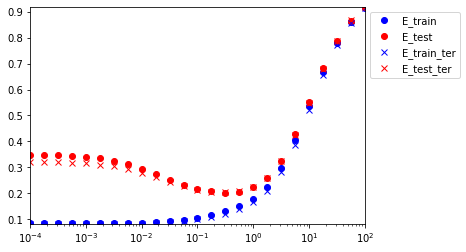

In [10]:
#Plots     
p11,=plt.plot(gammas,E_train,'bo')
p21,=plt.plot(gammas,E_test,'ro')
p12,=plt.plot(gammas,E_train_ter,'bx')
p22,=plt.plot(gammas,E_test_ter,'rx')
plt.xscale('log')
#plt.yscale('log')
plt.xlim( gammas[0],gammas[-1] )
plt.ylim(np.amin((E_train, E_train_ter) ),np.amax( (E_test, E_test_ter) ))
plt.legend([p11,p21, p12, p22], ["E_train", "E_test", "E_train_ter", "E_test_ter"],bbox_to_anchor=(1, 1), loc='upper left')
plt.show()